# The 'Perfect' Neighborhood
## Introduction
### Background
Finding the 'perfect' neighborhood is not an easy job for most of us. Sometime we know what we want out of a good neighborhood, but most of the time we just love the place without really knowing why we love it so much. As a common folk, this might not be a problem but for a real estate agent who have to face their client and giving the 'best' recommendation this wasn't an easy task. In this project we will explore how a problem like this can be tackled with data science by utilizing all the available data from the internet and neighborhood information from Foursquare API.
### Problem Definition
A client whose currently live in Little Saigon, San Fransisco, CA will move to Seattle, WA within a couple of months. He want to find a house with a similar neighborhood there, he explain some category for the 'perfect' neighborhood that he had in mind such as school for his kids, access to city park but he could't point out what he love the most about his current neighborhood. He just simply love it.
### Data Description
In order to solve his client problem, we need access to a couple of data:
* List of the [neighborhoods in San Fransisco](https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco)
* List of the [neighborhoods in Seattle](https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle)
* Venues information from Foursquare API for each neighborhood

### San Fransisco Data Gathering
#### Scraping Wikipedia
To get the neighborhoods data for San Fransisco, let scrape Wikipedia page for the data.
* create requests url using requests library
* use BeautifulSoup to scrape the page
* use browser web page inspector to get the idea of the page structure

In [48]:
import requests
#ping a website and return HTML of the website.
url = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco').text

from bs4 import BeautifulSoup
soup = BeautifulSoup(url,'html.parser')
#find the span class
dtable = soup.find_all('span',{'class':'mw-headline'})

The total neighborhoods data was scraped by finding all the `class: mw-headline` in the page, since all contain the name for each neighborhoods. However, the last four items isn't neighborhoods so we can just remove it when creating the dataframe. Let's extract the neighborhoods name from the class by extracting the `.text` attribute.

In [49]:
import pandas as pd

data=[]
for i in range(len(dtable)-4):
    #export the text
    data.append(dtable[i].text)

#create the dataframe
sf = pd.DataFrame(data)
sf = sf.rename(columns={0: 'Neighborhood'})
sf.head()

Neighborhood
0     Alamo Square
1       Anza Vista
2  Ashbury Heights
3      Balboa Park
4   Balboa Terrace

#### Getting geolocation of the neighborhoods
In this step we will use [OpenCageGeocode](https://opencagedata.com/) library that can provide forward/reverse geocoding. To get access to the _OpenCageGeocode_ API we can just simply sign up and use the free account with limited 2500 request/day, which will be more than enough for our project.

In [50]:
from opencage.geocoder import OpenCageGeocode

In [51]:
#Hide this cell
key = '*****' #hide the key
geocoder = OpenCageGeocode(key)

We can call the geocode API for each neighborhoods that we had and get the latitude/longitude data before assigning it to an empty list for each. In the end we convert the list as one of the column for our dataframe.

In [52]:
lat=[]
lon=[]
for i in sf['Neighborhood']:
    a = i+',San Fransisco, CA'
    #calling the geocode using the neighborhoods name
    loc = geocoder.geocode(a)
    lat.append(loc[0]['geometry']['lat'])
    lon.append(loc[0]['geometry']['lng'])

In [53]:
sf['Latitude']=lat
sf['Longitude']=lon
sf.head(10)

Neighborhood   Latitude   Longitude
0               Alamo Square  37.763366 -122.448109
1                 Anza Vista  37.780882 -122.448791
2            Ashbury Heights  37.775599 -122.448068
3                Balboa Park  37.777429 -122.459724
4             Balboa Terrace  37.777429 -122.459724
5                    Bayview  37.732431 -122.391521
6               Belden Place  37.790805 -122.403672
7             Bernal Heights  37.736112 -122.469886
8                Buena Vista  37.788226 -122.393306
9  Butchertown (Old and New)  37.734786 -122.469687

#### Explore & cluster the neighborhoods


In [54]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [55]:
# create map of San Fransisco using latitude and longitude values
loc = geocoder.geocode('Alamo Square, San Fransisco, CA')
latitude = loc[0]['geometry']['lat']
longitude = loc[0]['geometry']['lng']
map_sf = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(sf['Latitude'], sf['Longitude'], sf['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)  
    
map_sf

### Examine the Current Neighborhood
Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [56]:
# @hidden_cell
CLIENT_ID = '***** # your Foursquare ID
CLIENT_SECRET = '*****' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [57]:
#Function to get nearby venues using Foursquare API
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called `sf_venue`.

In [58]:
sf_venues = getNearbyVenues(names=sf['Neighborhood'],
                                   latitudes=sf['Latitude'],
                                   longitudes=sf['Longitude']
                                  )

Alamo Square
Anza Vista
Ashbury Heights
Balboa Park
Balboa Terrace
Bayview
Belden Place
Bernal Heights
Buena Vista
Butchertown (Old and New)
Castro
Cathedral Hill
Cayuga Terrace
China Basin
Chinatown
Civic Center
Clarendon Heights
Cole Valley
Corona Heights
Cow Hollow
Crocker-Amazon
Design District
Diamond Heights
Dogpatch
Dolores Heights
Duboce Triangle
Embarcadero
Eureka Valley
Excelsior
Fillmore
Financial District
Financial District South
Fisherman's Wharf
Forest Hill
Forest Knolls
Glen Park
Golden Gate Heights
Haight-Ashbury
Hayes Valley
Hunters Point
India Basin
Ingleside
Ingleside Terraces
Inner Sunset
Irish Hill
Islais Creek
Jackson Square
Japantown
Jordan Park
Laguna Honda
Lake Street
Lakeside
Lakeshore
Laurel Heights
Lincoln Manor
Little Hollywood
Little Russia
Little Saigon
Lone Mountain
Lower Haight
Lower Pacific Heights
Lower Nob Hill
Marina District
Merced Heights
Merced Manor
Midtown Terrace
Mid-Market
Miraloma Park
Mission Bay
Mission District
Mission Dolores
Mission Ter

In [59]:
print(sf_venues.shape)
sf_venues.head()

(4819, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Alamo Square              37.763366             -122.448109   
1  Alamo Square              37.763366             -122.448109   
2  Alamo Square              37.763366             -122.448109   
3  Alamo Square              37.763366             -122.448109   
4  Alamo Square              37.763366             -122.448109   

                Venue  Venue Latitude  Venue Longitude       Venue Category  
0       Mount Olympus       37.763306      -122.445543  Monument / Landmark  
1               Zazie       37.765282      -122.449919       Breakfast Spot  
2       Cole Hardware       37.765221      -122.449550       Hardware Store  
3  Adel's Wine Cellar       37.761543      -122.448889             Wine Bar  
4          Say Cheese       37.765974      -122.450019          Cheese Shop

Let's check how many venues returned by neighborhood,

In [60]:
sf_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
Alamo Square                                  45                      45   
Anza Vista                                    40                      40   
Ashbury Heights                               27                      27   
Balboa Park                                   62                      62   
Balboa Terrace                                62                      62   
Bayview                                       23                      23   
Belden Place                                 100                     100   
Bernal Heights                                33                      33   
Buena Vista                                  100                     100   
Butchertown (Old and New)                     36                      36   
Castro                                        47                      47   
Cathedral Hill                                33                      33   
Cayuga Terrace                                 2                       2   
China Basin                                   75                      75   
Chinatown                                    100                     100   
Civic Center                                  63                      63   
Clarendon Heights                             33                      33   
Cole Valley                                   24                      24   
Corona Heights                                 5                       5   
Cow Hollow                                    43                      43   
Crocker-Amazon                                33                      33   
Design District                               33                      33   
Diamond Heights                               87                      87   
Dogpatch                                      62                      62   
Dolores Heights                               97                      97   
Duboce Triangle                               33                      33   
Embarcadero                                   36                      36   
Eureka Valley                                 76                      76   
Excelsior                                     36                      36   
Fillmore                                      79                      79   
Financial District                            33                      33   
Financial District South                      33                      33   
Fisherman's Wharf                             33                      33   
Forest Hill                                    6                       6   
Forest Knolls                                  9                       9   
Glen Park                                     32                      32   
Golden Gate Heights                           33                      33   
Haight-Ashbury                                33                      33   
Hayes Valley                                  64                      64   
Hunters Point                                  4                       4   
India Basin                                   35                      35   
Ingleside                                     33                      33   
Ingleside Terraces                            33                      33   
Inner Sunset                                  35                      35   
Irish Hill                                   100                     100   
Islais Creek                                  12                      12   
Jackson Square                                95                      95   
Japantown                                     33                      33   
Jordan Park                                   33                      33   
Laguna Honda                                   4                       4   
Lake Street                                   54                      54   

we can also check how many uniques value in the venues returned by Foursquare API.

In [61]:
print('There are {} uniques categories.'.format(len(sf_venues['Venue Category'].unique())))

There are 312 uniques categories.


We can do a onehot encoding to analyze each neighborhood and use it to find the average amount of each venues category showed in each neighborhood

In [62]:
# one hot encoding
sf_onehot = pd.get_dummies(sf_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_onehot['Neighborhood'] = sf_venues['Neighborhood'] 

# move neighborhood column to the first column
sf_onehot.set_index(['Neighborhood'], inplace=True)
sf_onehot.reset_index(level=['Neighborhood'], inplace=True)
print (sf_onehot.shape)
sf_onehot.head()

(4819, 312)


Neighborhood  ATM  Acai House  Accessories Store  Adult Boutique  \
0  Alamo Square    0           0                  0               0   
1  Alamo Square    0           0                  0               0   
2  Alamo Square    0           0                  0               0   
3  Alamo Square    0           0                  0               0   
4  Alamo Square    0           0                  0               0   

   African Restaurant  Alternative Healer  American Restaurant  Antique Shop  \
0                   0                   0                    0             0   
1                   0                   0                    0             0   
2                   0                   0                    0             0   
3                   0                   0                    0             0   
4                   0                   0                    0             0   

   Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0         0       0                 0                       0            0   
1         0       0                 0                       0            0   
2         0       0                 0                       0            0   
3         0       0                 0                       0            0   
4         0       0                 0                       0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0           0                    0                 0                   0   
1           0                    0                 0                   0   
2           0                    0                 0                   0   
3           0                    0                 0                   0   
4           0                    0                 0                   0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0                0          0           0           0       0     0    0   
1                0          0           0           0       0     0    0   
2                0          0           0           0       0     0    0   
3                0          0           0           0       0     0    0   
4                0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Bath House  Beach  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0           0      0                0         0            0           0   
1           0      0                0         0            0           0   
2           0      0                0         0            0           0   
3           0      0                0         0            0           0   
4           0      0                0         0            0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  \
0              0                         0          0       0           0   
1              0                         0          0       0           0   
2              0                         0          0       0           0   
3              0                         0          0       0           0   
4              0                         0          0       0           0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Bowling Green  \
0              0          0         0              0              0   
1              0          0         0              0              0   
2              0          0         0              0              0   
3              0          0         0        

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [107]:
sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()
sf_grouped

Neighborhood       ATM  Acai House  Accessories Store  \
0                 Alamo Square  0.000000    0.000000           0.000000   
1                   Anza Vista  0.000000    0.000000           0.000000   
2              Ashbury Heights  0.000000    0.000000           0.000000   
3                  Balboa Park  0.000000    0.000000           0.000000   
4               Balboa Terrace  0.000000    0.000000           0.000000   
5                      Bayview  0.000000    0.000000           0.000000   
6                 Belden Place  0.000000    0.000000           0.000000   
7               Bernal Heights  0.000000    0.000000           0.000000   
8                  Buena Vista  0.000000    0.000000           0.000000   
9    Butchertown (Old and New)  0.027778    0.000000           0.000000   
10                      Castro  0.000000    0.000000           0.000000   
11              Cathedral Hill  0.000000    0.000000           0.000000   
12              Cayuga Terrace  0.000000    0.000000           0.000000   
13                 China Basin  0.000000    0.000000           0.000000   
14                   Chinatown  0.000000    0.000000           0.000000   
15                Civic Center  0.000000    0.000000           0.000000   
16           Clarendon Heights  0.000000    0.000000           0.000000   
17                 Cole Valley  0.000000    0.000000           0.000000   
18              Corona Heights  0.000000    0.000000           0.000000   
19                  Cow Hollow  0.000000    0.000000           0.000000   
20              Crocker-Amazon  0.000000    0.000000           0.000000   
21             Design District  0.000000    0.000000           0.000000   
22             Diamond Heights  0.000000    0.000000           0.000000   
23                    Dogpatch  0.000000    0.000000           0.016129   
24             Dolores Heights  0.000000    0.000000           0.000000   
25             Duboce Triangle  0.000000    0.000000           0.000000   
26                 Embarcadero  0.000000    0.000000           0.000000   
27               Eureka Valley  0.000000    0.000000           0.000000   
28                   Excelsior  0.000000    0.000000           0.000000   
29                    Fillmore  0.000000    0.000000           0.000000   
30          Financial District  0.000000    0.000000           0.000000   
31    Financial District South  0.000000    0.000000           0.000000   
32           Fisherman's Wharf  0.000000    0.000000           0.000000   
33                 Forest Hill  0.000000    0.000000           0.000000   
34               Forest Knolls  0.000000    0.000000           0.000000   
35                   Glen Park  0.000000    0.000000           0.000000   
36         Golden Gate Heights  0.000000    0.000000           0.000000   
37              Haight-Ashbury  0.000000    0.000000           0.000000   
38                Hayes Valley  0.000000    0.000000           0.000000   
39               Hunters Point  0.000000    0.000000           0.000000   
40                 India Basin  0.000000    0.000000           0.000000   
41                   Ingleside  0.000000    0.000000           0.000000   
42          Ingleside Terraces  0.000000    0.000000           0.000000   
43                Inner Sunset  0.000000    0.000000           0.000000   
44                  Irish Hill  0.000000    0.000000           0.000000   
45                Islais Creek  0.000000    0.000000           0.000000   
46              Jackson Square  0.000000    0.010526           0.000000   
47                   Japantown  0.000000    0.000000           0.000000   
48                 Jordan Park  0.000000    0.000000           0.030303   
49                Laguna Honda  0.000000    0.000000           0.000000   
50                 Lake Street  0.000000    0.000000           0.018519   
51                   Lakeshore  0.000000    0.000000           0.000000   
52                    Lakeside  0.000000   

In [108]:
sf_grouped.shape

(119, 312)

In [109]:
num_top_venues = 5

for hood in sf_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sf_grouped[sf_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alamo Square----
            venue  freq
0     Bus Station  0.07
1  Breakfast Spot  0.07
2            Park  0.04
3           Trail  0.04
4        Wine Bar  0.04


----Anza Vista----
                     venue  freq
0              Coffee Shop  0.08
1                 Wine Bar  0.05
2  Health & Beauty Service  0.05
3           Cosmetics Shop  0.05
4      Japanese Restaurant  0.05


----Ashbury Heights----
         venue  freq
0         Café  0.15
1  Coffee Shop  0.11
2         Bank  0.07
3      Brewery  0.04
4  Supermarket  0.04


----Balboa Park----
                venue  freq
0    Sushi Restaurant  0.06
1                 Bar  0.06
2  Chinese Restaurant  0.06
3  Italian Restaurant  0.05
4         Pizza Place  0.05


----Balboa Terrace----
                venue  freq
0    Sushi Restaurant  0.06
1                 Bar  0.06
2  Chinese Restaurant  0.06
3  Italian Restaurant  0.05
4         Pizza Place  0.05


----Bayview----
                             venue  freq
0  Southern / Soul Foo

                venue  freq
0                Park  0.12
1  Light Rail Station  0.06
2                Café  0.06
3  Chinese Restaurant  0.06
4     Thai Restaurant  0.06


----Outer Mission----
                 venue  freq
0          Coffee Shop  0.15
1           Food Truck  0.05
2  Japanese Restaurant  0.04
3                 Park  0.04
4                  Gym  0.04


----Outer Sunset----
                venue  freq
0  Mexican Restaurant  0.09
1  Chinese Restaurant  0.09
2          Donut Shop  0.06
3         Pizza Place  0.06
4              Bakery  0.06


----Pacific Heights----
                     venue  freq
0             Cocktail Bar  0.04
1  New American Restaurant  0.04
2       Italian Restaurant  0.04
3              Men's Store  0.04
4                     Café  0.04


----Parkmerced----
                  venue  freq
0                  Park  0.09
1           Pizza Place  0.06
2                   Pub  0.06
3    Chinese Restaurant  0.06
4  Gym / Fitness Center  0.06


----Parkside----

### Let's put the data into a dataframe

Write a function to sort the venues in the descending orders

In [110]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [226]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sf_grouped['Neighborhood']

for ind in np.arange(sf_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sf_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0     Alamo Square        Breakfast Spot           Bus Station   
1       Anza Vista           Coffee Shop   Japanese Restaurant   
2  Ashbury Heights                  Café           Coffee Shop   
3      Balboa Park    Chinese Restaurant      Sushi Restaurant   
4   Balboa Terrace    Chinese Restaurant      Sushi Restaurant   

  3rd Most Common Venue      4th Most Common Venue  \
0              Wine Bar          Convenience Store   
1              Wine Bar    Health & Beauty Service   
2                  Bank  Middle Eastern Restaurant   
3                   Bar         Italian Restaurant   
4                   Bar         Italian Restaurant   

         5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                         Park           Coffee Shop                 Trail   
1               Cosmetics Shop    Mexican Restaurant                Bakery   
2  Eastern European Restaurant     Outdoor Sculpture    Mexican Restaurant   
3                  Pizza Place        Massage Studio   Japanese Restaurant   
4                  Pizza Place        Massage Studio   Japanese Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0        Ice Cream Shop     Food & Drink Shop              Gift Shop  
1       Thai Restaurant           Gas Station       Sushi Restaurant  
2           Supermarket                  Park                Dog Run  
3             Pet Store                  Café                   Park  
4             Pet Store                  Café                   Park

### Cluster the neighborhoods
Running an elbow plot for the k value will have to identify the right k

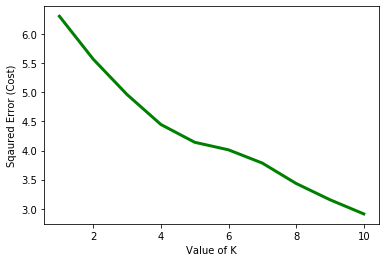

In [137]:
import matplotlib.pyplot as plt  
from matplotlib import style 

sf_grouped_clustering = sf_grouped.drop('Neighborhood', 1)

cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(sf_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 

From above plot finding the right k wasn't easy since the elbow is not prominent, but for the purpose of this project I use k = 4 because after testing several k value I always get Little Saigon in the same cluster.
#### Running k-means Clustering

In [138]:
#set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 3], dtype=int32)

#### Adding Cluster Label and Merged Dataframe

In [139]:
#create merged dataframe
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sf_merged = sf

# merge sf_grouped with sf_data to add latitude/longitude for each neighborhood
sf_merged = sf_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

sf_merged.head() # check the last columns!

Neighborhood   Latitude   Longitude  Cluster Labels  \
0     Alamo Square  37.763366 -122.448109               0   
1       Anza Vista  37.780882 -122.448791               0   
2  Ashbury Heights  37.775599 -122.448068               0   
3      Balboa Park  37.777429 -122.459724               0   
4   Balboa Terrace  37.777429 -122.459724               0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0        Breakfast Spot           Bus Station              Wine Bar   
1           Coffee Shop   Japanese Restaurant              Wine Bar   
2                  Café           Coffee Shop                  Bank   
3    Chinese Restaurant      Sushi Restaurant                   Bar   
4    Chinese Restaurant      Sushi Restaurant                   Bar   

       4th Most Common Venue        5th Most Common Venue  \
0          Convenience Store                         Park   
1    Health & Beauty Service               Cosmetics Shop   
2  Middle Eastern Restaurant  Eastern European Restaurant   
3         Italian Restaurant                  Pizza Place   
4         Italian Restaurant                  Pizza Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Coffee Shop                 Trail        Ice Cream Shop   
1    Mexican Restaurant                Bakery       Thai Restaurant   
2     Outdoor Sculpture    Mexican Restaurant           Supermarket   
3        Massage Studio   Japanese Restaurant             Pet Store   
4        Massage Studio   Japanese Restaurant             Pet Store   

  9th Most Common Venue 10th Most Common Venue  
0     Food & Drink Shop              Gift Shop  
1           Gas Station       Sushi Restaurant  
2                  Park                Dog Run  
3                  Café                   Park  
4                  Café                   Park

In [140]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged['Latitude'], sf_merged['Longitude'], sf_merged['Neighborhood'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analyze San Fransisco neighborhood
Our client currently live in Little Saigon, now let's take a look which cluster it's fall too and what make it special by analyzing three most common venues in the neighborhood of Little Saigon.

In [141]:
sf_merged.loc[sf_merged['Neighborhood']=='Little Saigon']

Neighborhood   Latitude   Longitude  Cluster Labels  \
57  Little Saigon  37.741783 -122.432225               2   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
57                 Trail                  Park               Dog Run   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
57        Scenic Lookout    Chinese Restaurant                  Café   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
57            Playground        Breakfast Spot  Ethiopian Restaurant   

   10th Most Common Venue  
57            Event Space

As we can see, Little Saigon is fall under cluster label two (2) which we can use to identify what so special about the neighborhood by looking at the most common venues.

In [118]:
clust = sf_merged.loc[sf_merged['Cluster Labels'] == 2]

#### 1st Most Common Venue
Let's start with the 1st most common venue in Cluster 2. We can utilize a bar chart to understand which venues has the highest frequency.

Bus Stop               1
Japanese Restaurant    2
Music Venue            1
Park                   4
Scenic Lookout         1
Trail                  5
Name: 1st Most Common Venue, dtype: int64

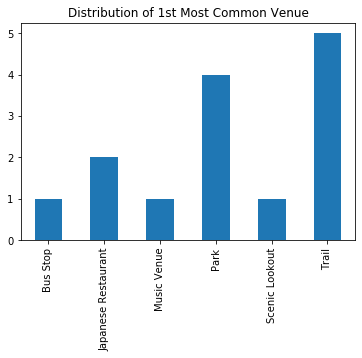

In [101]:
venues_counts = clust['1st Most Common Venue'].value_counts().sort_index()
venues_counts.plot(kind='bar', title='Distribution of 1st Most Common Venue')
venues_counts

#### 2nd Most Common Venue
In the 1st most common venue, both **Park** and **Trail** has the highest frequency in Cluster 2 neighborhood. Let's take a look at the 2nd most common venue.

Bookstore             1
Bus Stop              1
Grocery Store         1
Hotpot Restaurant     1
Insurance Office      1
Light Rail Station    2
Park                  4
Playground            1
Pool                  1
Tennis Court          1
Name: 2nd Most Common Venue, dtype: int64

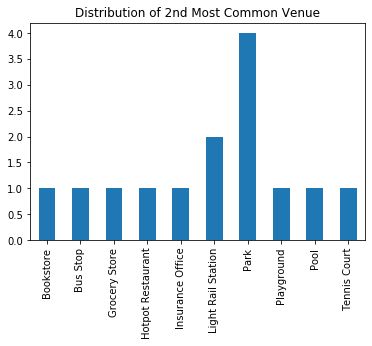

In [119]:
venues_counts = clust['2nd Most Common Venue'].value_counts().sort_index()
venues_counts.plot(kind='bar', title='Distribution of 2nd Most Common Venue')
venues_counts

#### 3rd Most Common Venue
In the 2nd most commone venue, **Park** also come out as the most common venue in Cluster 2. Now let's take a look at the 3rd one.

Brewery                1
Coffee Shop            1
Dog Run                1
Garden                 1
Japanese Restaurant    2
Mountain               2
Museum                 1
Park                   1
Tennis Court           1
Trail                  2
Zoo Exhibit            1
Name: 3rd Most Common Venue, dtype: int64

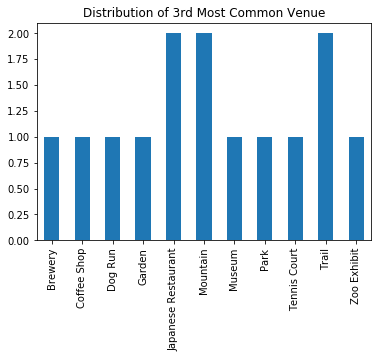

In [105]:
venues_counts = clust['3rd Most Common Venue'].value_counts().sort_index()
venues_counts.plot(kind='bar', title='Distribution of 3rd Most Common Venue')
venues_counts

After looking at the frequency of each unique venue in the **1st-3rd Most Common Venue** in Cluster 2, we could see clearly that **Park** and **Trail** being the most common one. From this fact, it's clear that neighborhood in Cluster 2 provide the best recreational area which make our client love it.

### Seattle Data Gathering
#### Scraping Wikipedia

In [183]:
import requests
#ping a website and return HTML of the website.
url = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle').text

from bs4 import BeautifulSoup
soup = BeautifulSoup(url,'html.parser')
#find the table class "wikitable sortable"
dtable = soup.find('table',{'class':'wikitable sortable'})

In [199]:
drow = dtable.findChildren(['tr'])

#iterate the row and append the value into a list called tes
data=[]
for row in drow:
    cells = row.find('td')
    if cells != None:
        val = cells.text
        #I need to do several clean-up on the value to make sure I didn't get an error when using the neighborhood list with FoursquareAPI
        val = val.replace('\n','')
        val = val.replace(' /',',')
        val = ''.join([i for i in val if not i.isdigit()])
        val = val.replace('[]','')
        val = val.replace('(',', ')
        val = val.replace(')','')
        val = val.replace(', Seattle','')
        data.append(val)

#create the dataframe
seat = pd.DataFrame(data)
seat = seat.rename(columns={0: 'Neighborhood'})
seat.head(10)

Neighborhood
0                       North Seattle
1                           Broadview
2                         Bitter Lake
3             North Beach, Blue Ridge
4                          Crown Hill
5                           Greenwood
6                           Northgate
7                         Haller Lake
8                           Pinehurst
9  North College Park, Licton Springs

#### Assigning Geolocation to Seattle Data

In [200]:
lat=[]
lon=[]
for i in seat['Neighborhood']:
    a = i+',Seattle, WA'
    #calling the geocode using the neighborhoods name
    loc = geocoder.geocode(a)
    lat.append(loc[0]['geometry']['lat'])
    lon.append(loc[0]['geometry']['lng'])
    
seat['Latitude']=lat
seat['Longitude']=lon
seat.head(10)

Neighborhood   Latitude   Longitude
0                       North Seattle  47.660773 -122.291497
1                           Broadview  47.722320 -122.360407
2                         Bitter Lake  47.726236 -122.348764
3             North Beach, Blue Ridge  47.747786 -122.374953
4                          Crown Hill  47.694715 -122.371459
5                           Greenwood  47.690981 -122.354877
6                           Northgate  47.713153 -122.321231
7                         Haller Lake  47.719748 -122.333751
8                           Pinehurst  47.603832 -122.330062
9  North College Park, Licton Springs  47.611534 -122.318072

#### Create Map of Seattle Neighborhood

In [186]:
# create map of Seattle using latitude and longitude values
loc = geocoder.geocode('Seattle, WA')
latitude = loc[0]['geometry']['lat']
longitude = loc[0]['geometry']['lng']
map_seat = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(seat['Latitude'], seat['Longitude'], seat['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seat)  
    
map_seat

#### Get Venues Data from FoursquareAPI

In [202]:
seat_venues = getNearbyVenues(names=seat['Neighborhood'],
                                   latitudes=seat['Latitude'],
                                   longitudes=seat['Longitude']
                                  )

North Seattle
Broadview
Bitter Lake
North Beach, Blue Ridge
Crown Hill
Greenwood
Northgate
Haller Lake
Pinehurst
North College Park, Licton Springs
Maple Leaf
Lake City
Cedar Park
Matthews Beach
Meadowbrook
Olympic Hills
Victory Heights
Wedgwood
View Ridge
Sand Point
Roosevelt
Ravenna
Bryant
Windermere
Hawthorne Hills
Laurelhurst
University District , U District
University Village
Wallingford
Northlake
Green Lake
Fremont
Phinney Ridge
Ballard
West Woodland
Whittier Heights
Adams
Sunset Hill
Loyal Heights
Central Seattle
Magnolia
Lawton Park
Briarcliff
Southeast Magnolia
Interbay
Queen Anne
North Queen Anne
East Queen Anne
Lower Queen Anne
West Queen Anne
Capitol Hill
Portage Bay, Roanoke
Broadway
Pike-Pine Corridor, Pike/Pine
Montlake
Stevens
Interlaken
Madison Valley
Renton Hill
Madison Park
Broadmoor
Lake Union
South Lake Union
Cascade
Westlake
Eastlake
Downtown
Denny Triangle
Belltown
Pike-Market
Central Business District
First Hill
Pioneer Square
International District , "ID"
Yesle

In [205]:
print (seat_venues.shape)
seat_venues.head()

(3325, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  North Seattle              47.660773             -122.291497   
1  North Seattle              47.660773             -122.291497   
2  North Seattle              47.660773             -122.291497   
3  North Seattle              47.660773             -122.291497   
4  North Seattle              47.660773             -122.291497   

                           Venue  Venue Latitude  Venue Longitude  \
0   Burke-Gilman Brewing Company       47.661308      -122.288067   
1                    Jak's Grill       47.661072      -122.288073   
2  Center for Urban Horticulture       47.657978      -122.290237   
3                   Burgermaster       47.661561      -122.293952   
4                 Baskin-Robbins       47.661336      -122.292004   

             Venue Category  
0                   Brewery  
1                Steakhouse  
2  College Science Building  
3              Burger Joint  
4            Ice Cream Shop

In [207]:
seat_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                              
Adams                                                                 3   
Alki Point                                                            5   
Arbor Heights                                                         1   
Atlantic                                                             11   
Ballard                                                               9   
Beacon Hill                                                          19   
Belltown                                                             69   
Bitter Lake                                                          27   
Briarcliff                                                            4   
Brighton                                                              3   
Broadmoor                                                             4   
Broadview                                                             9   
Broadway                                                             38   
Bryant                                                                2   
Capitol Hill                                                         49   
Cascade                                                              58   
Cedar Park                                                            2   
Central Area, Central District , "CD"                               100   
Central Business District                                            79   
Central Seattle                                                      25   
Central Waterfront                                                   99   
Cherry Hill & Squire Park                                             1   
Columbia City                                                        36   
Crown Hill                                                           13   
Delridge                                                              8   
Denny Triangle                                                       63   
Downtown                                                             72   
Dunlap, Othello                                                       5   
East Queen Anne                                                      50   
Eastlake                                                             24   
Fairmount Park                                                       39   
Fauntleroy                                                           10   
First Hill                                                           43   
Fremont                                                              61   
Gatewood                                                              6   
Genesee                                                               5   
Georgetown                                                           35   
Green Lake                                                            8   
Greenwood                                                            46   
Haller Lake                                                           5   
Harrison, Denny-Blaine                                                1   
Hawthorne Hills                                                       8   
High Point                                                            5   
Highland Park                                                         5   
Hillman City                                                         12   
Holly Park, NewHolly                                                  6   
Industrial District                                                  35   
Interbay                                                             12   
Interlaken                                                            4   
International District , "ID"                                         8   
Judkins Park                                                         18   
Junction, West Seattle Junction, Alaska Junction                     14   


In [208]:
print('There are {} uniques categories.'.format(len(seat_venues['Venue Category'].unique())))

There are 318 uniques categories.


### Examine Seattle Neighborhood
#### Running onehot encoding

In [209]:
# one hot encoding
seat_onehot = pd.get_dummies(seat_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seat_onehot['Neighborhood'] = seat_venues['Neighborhood'] 

# move neighborhood column to the first column
seat_onehot.set_index(['Neighborhood'], inplace=True)
seat_onehot.reset_index(level=['Neighborhood'], inplace=True)
print (seat_onehot.shape)
seat_onehot.head()

(3325, 318)


Neighborhood  ATM  Accessories Store  African Restaurant  Airport  \
0  North Seattle    0                  0                   0        0   
1  North Seattle    0                  0                   0        0   
2  North Seattle    0                  0                   0        0   
3  North Seattle    0                  0                   0        0   
4  North Seattle    0                  0                   0        0   

   American Restaurant  Antique Shop  Aquarium  Arcade  \
0                    0             0         0       0   
1                    0             0         0       0   
2                    0             0         0       0   
3                    0             0         0       0   
4                    0             0         0       0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Australian Restaurant  Auto Workshop  \
0                 0                   0                      0              0   
1                 0                   0                      0              0   
2                 0                   0                      0              0   
3                 0                   0                      0              0   
4                 0                   0                      0              0   

   Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0          0           0       0     0    0               0   
1                0          0           0       0     0    0               0   
2                0          0           0       0     0    0               0   
3                0          0           0       0     0    0               0   
4                0          0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  \
0                 0                 0                   0      0   
1                 0                 0                   0      0   
2                 0                 0                   0      0   
3                 0                 0                   0      0   
4                 0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0                0         0            0           0              0   
1                0         0            0           0              0   
2                0         0            0           0              0   
3                0         0            0           0              0   
4                0         0            0           0              0   

   Bike Shop  Bike Trail  Bistro  Boat or Ferry  Bookstore  Botanical Garden  \
0          0           0       0              0          0                 0   
1          0           0       0              0          0                 0   
2          0           0       0              0          0                 0   
3          0           0       0              0          0                 0   
4          0           0       0              0          0                 0   

   Boutique  Bowling Alley  Bowling Green  Boxing Gym  Breakfast Spot  \
0         0              0              0           0               0   
1         0              0              0           0               0   
2         0              0              0           0               0   
3         0              0              0           0               0   
4         0              0              0           0               0   

   Brewery  Bridal Shop  Bubble Tea

In [210]:
seat_grouped = seat_onehot.groupby('Neighborhood').mean().reset_index()
seat_grouped

Neighborhood       ATM  \
0                                               Adams  0.000000   
1                                          Alki Point  0.000000   
2                                       Arbor Heights  0.000000   
3                                            Atlantic  0.000000   
4                                             Ballard  0.000000   
5                                         Beacon Hill  0.000000   
6                                            Belltown  0.000000   
7                                         Bitter Lake  0.037037   
8                                          Briarcliff  0.000000   
9                                            Brighton  0.000000   
10                                          Broadmoor  0.000000   
11                                          Broadview  0.000000   
12                                           Broadway  0.000000   
13                                             Bryant  0.000000   
14                                       Capitol Hill  0.020408   
15                                            Cascade  0.000000   
16                                         Cedar Park  0.000000   
17              Central Area, Central District , "CD"  0.000000   
18                          Central Business District  0.000000   
19                                    Central Seattle  0.000000   
20                                 Central Waterfront  0.000000   
21                          Cherry Hill & Squire Park  0.000000   
22                                      Columbia City  0.000000   
23                                         Crown Hill  0.000000   
24                                           Delridge  0.000000   
25                                     Denny Triangle  0.000000   
26                                           Downtown  0.000000   
27                                    Dunlap, Othello  0.000000   
28                                    East Queen Anne  0.000000   
29                                           Eastlake  0.000000   
30                                     Fairmount Park  0.000000   
31                                         Fauntleroy  0.000000   
32                                         First Hill  0.023256   
33                                            Fremont  0.000000   
34                                           Gatewood  0.000000   
35                                            Genesee  0.000000   
36                                         Georgetown  0.028571   
37                                         Green Lake  0.000000   
38                                          Greenwood  0.000000   
39                                        Haller Lake  0.000000   
40                             Harrison, Denny-Blaine  0.000000   
41                                    Hawthorne Hills  0.000000   
42                                         High Point  0.000000   
43                                      Highland Park  0.000000   
44                                       Hillman City  0.000000   
45                               Holly Park, NewHolly  0.000000   
46                                Industrial District  0.000000   
47                                           Interbay  0.000000   
48                                         Interlaken  0.000000   
49                      International District , "ID"  0.000000   
50                                       Judkins Park  0.000000   
51   Junction, West Seattle Junction, Alaska Junction  0.000000   
52                                          Lake City  0.000000   
53                                         Lake Union  0.000000   
54                                           Lakewood  0.000000   
55                                        Laurelhurst  0.000000   
56                                        Lawton Park  0.000000   
57                                             Leschi  0.000000   
58                                   Lower Queen Anne  0.000000   
59                   

In [211]:
seat_grouped.shape

(126, 318)

In [213]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
seat_venues_sorted = pd.DataFrame(columns=columns)
seat_venues_sorted['Neighborhood'] = seat_grouped['Neighborhood']

for ind in np.arange(seat_grouped.shape[0]):
    seat_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seat_grouped.iloc[ind, :], num_top_venues)

seat_venues_sorted.head()

Neighborhood     1st Most Common Venue 2nd Most Common Venue  \
0          Adams  Mediterranean Restaurant    Light Rail Station   
1     Alki Point                     Beach        Baseball Field   
2  Arbor Heights                      Park           Zoo Exhibit   
3       Atlantic               Cheese Shop          Intersection   
4        Ballard               Coffee Shop     French Restaurant   

         3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                          Gym           Zoo Exhibit  Fast Food Restaurant   
1             Baseball Stadium            Lighthouse           Zoo Exhibit   
2  Eastern European Restaurant  Ethiopian Restaurant           Event Space   
3           Light Rail Station              Bus Stop         Grocery Store   
4                          Bar                  Park         Jewelry Store   

  6th Most Common Venue 7th Most Common Venue   8th Most Common Venue  \
0           Event Space            Eye Doctor             Fabric Shop   
1  Fast Food Restaurant           Fabric Shop                    Fair   
2            Eye Doctor           Fabric Shop                    Fair   
3  Marijuana Dispensary     Electronics Store  Thrift / Vintage Store   
4          Soccer Field            Restaurant          Baseball Field   

  9th Most Common Venue 10th Most Common Venue  
0                  Fair     Falafel Restaurant  
1    Falafel Restaurant         Farmers Market  
2    Falafel Restaurant         Farmers Market  
3            Food Truck    Rental Car Location  
4            Food Truck    Filipino Restaurant

## Result & Discussion
Analyzing the whole neighborhood in San Fransisco and applied clustering able to help understanding the current neighborhoods in Little Saigon. Narrowed down to the cluster where Little Saigon belonged to and analyzing the most common venues distribution in the cluster, I can identify what is the most visible venues in the neighborhood, which is Park/Trail. Little Saigon neighborhoods have a lot of venue which can be used as a recreational area which is the reason why it is lovable neighborhood.
Moving out to Seattle, after the same analysis was carried on Seattle data finding the 'perfect' neighborhood which match what Little Saigon have is very straight forward. I can find the list of neighborhood by locating the neighborhood with _Park/Trail_ as the **1st Most Common Venue**.

#### Finding All Neighborhood with Park/Trail as the 1st Most Common Venue

In [228]:
seat_venues_sorted.loc[seat_venues_sorted['1st Most Common Venue']=='Park']

Neighborhood 1st Most Common Venue       2nd Most Common Venue  \
2             Arbor Heights                  Park                 Zoo Exhibit   
34                 Gatewood                  Park                 Coffee Shop   
37               Green Lake                  Park                     Theater   
40   Harrison, Denny-Blaine                  Park                 Zoo Exhibit   
48               Interlaken                  Park              Scenic Lookout   
50             Judkins Park                  Park                 Bus Station   
57                   Leschi                  Park                   Pet Store   
81                Northlake                  Park          Seafood Restaurant   
114              View Ridge                  Park  Construction & Landscaping   
117                Wedgwood                  Park                 Coffee Shop   
121           West Woodland                  Park        Caribbean Restaurant   

           3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
2    Eastern European Restaurant  Ethiopian Restaurant           Event Space   
34                     Pet Store                   Gym   Dumpling Restaurant   
37                          Lake                 Trail          Tennis Court   
40   Eastern European Restaurant  Ethiopian Restaurant           Event Space   
48                   Zoo Exhibit    Falafel Restaurant     Electronics Store   
50                         Trail                Tunnel            Skate Park   
57                    Playground           Pizza Place              Bus Stop   
81                      Bus Stop           Art Gallery      Tapas Restaurant   
114                     Bus Stop           Zoo Exhibit  Fast Food Restaurant   
117                          ATM              Pharmacy            Steakhouse   
121                Bowling Green                 Trail      Asian Restaurant   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
2              Eye Doctor           Fabric Shop                  Fair   
34      Electronics Store  Ethiopian Restaurant           Event Space   
37                  Beach           Zoo Exhibit  Ethiopian Restaurant   
40             Eye Doctor           Fabric Shop                  Fair   
48   Ethiopian Restaurant           Event Space            Eye Doctor   
50    Japanese Restaurant                Museum               Dog Run   
57          Grocery Store           Zoo Exhibit  Ethiopian Restaurant   
81                   Café          Gourmet Shop                Lounge   
114           Event Space            Eye Doctor           Fabric Shop   
117           Supermarket                Lounge                   Gym   
121    Falafel Restaurant  Ethiopian Restaurant           Event Space   

    9th Most Common Venue       10th Most Common Venue  
2      Falafel Restaurant               Farmers Market  
34             Eye Doctor                  Fabric Shop  
37             Eye Doctor                  Fabric Shop  
40     Falafel Restaurant               Farmers Market  
48            Fabric Shop                         Fair  
50        Warehouse Store         Gym / Fitness Center  
57            Event Space                   Eye Doctor  
81          Boat or Ferry  Eastern European Restaurant  
114                  Fair           Falafel Restaurant  
117           Video Store                         Bank  
121            Eye Doctor                  Fabric Shop

In [216]:
seat_venues_sorted.loc[seat_venues_sorted['1st Most Common Venue']=='Trail']

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
45  Holly Park, NewHolly                 Trail        Baseball Field   
67        Matthews Beach                 Trail                  Park   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
45             BBQ Joint            Smoke Shop                   Bar   
67            Playground           Zoo Exhibit        Farmers Market   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
45        Farmers Market  Ethiopian Restaurant           Event Space   
67  Ethiopian Restaurant           Event Space            Eye Doctor   

   9th Most Common Venue 10th Most Common Venue  
45            Eye Doctor            Fabric Shop  
67           Fabric Shop                   Fair

#### 1st Most Common Venue Distribution in Seattle

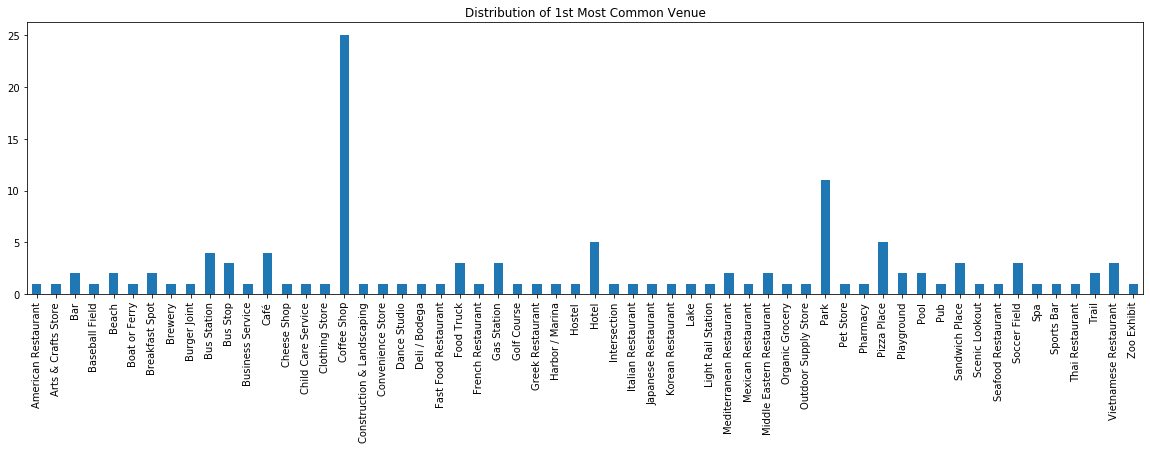

In [222]:
venues_counts = seat_venues_sorted['1st Most Common Venue'].value_counts().sort_index()
venues_counts.plot(kind='bar', title='Distribution of 1st Most Common Venue', figsize=(20,5))

#### 1st Most Common Venue Distribution in San Fransisco

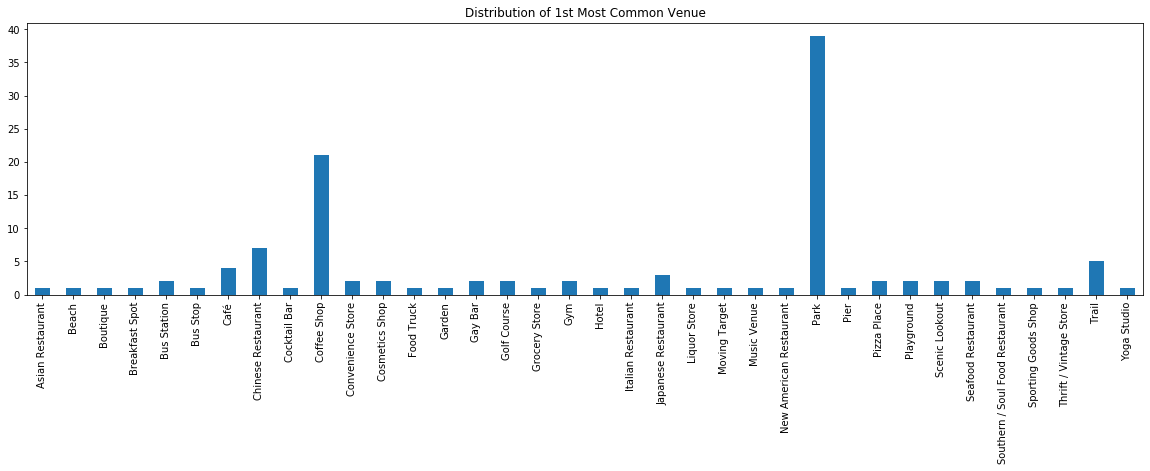

In [225]:
venues_counts = sf_merged['1st Most Common Venue'].value_counts().sort_index()
venues_counts.plot(kind='bar', title='Distribution of 1st Most Common Venue', figsize=(20,5))

From the above distribution, the most prominent feature of both city are _Coffee Shop_ and _Park_. In term of venues distribution both Seattle and San Fransisco are pretty much similar, which means the living experience will be pretty much the same if we rely on the similar activity that can be done in both city.

## Conclusions
Both Seattle and San Fransisco are similar in every way, both city has large recreational area offering such as _Park/Trail_ and a bunch of _Coffee Shop_ in the area. Moving from Little Saigon, San Fransisco to a similar neighborhood in Seattle wouldn't be a problem, given the same living experience can be provided in Seattle.